<a href="https://colab.research.google.com/github/PaninaEkaterina/statprak/blob/main/7_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Подготовка**

In [ ]:
# Делаем необходимые импорты
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Загрузка файла
import gdown
url = "https://drive.google.com/uc?id=1Z39LNnF4lOj4iT48YDYFZNPDBglMd0TZ"
filename = "forest_dataset.csv"
gdown.download(url, filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Z39LNnF4lOj4iT48YDYFZNPDBglMd0TZ
To: /content/forest_dataset.csv
100%|██████████| 1.29M/1.29M [00:00<00:00, 137MB/s]


'forest_dataset.csv'

In [ ]:
# Загрузка данных
data = pd.read_csv(filename)
# Выделяем метки и признаки
labels = data[data.columns[-1]].values
feature_matrix = data[data.columns[:-1]].values
# Разделяем данные
train_feature_matrix, test_feature_matrix, train_labels, test_labels \
  = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

# Homework

Качество классификации / регрессии методом k ближайших соседей зависит от нескольких параметров:

-количество соседей n_neighbors

-метрика расстояния между объектами metric

-веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем меньше учитывается его "голос") weights

Подготовим `KNeighborsClassifier` для набора данных.

In [ ]:
# Обучаем модель K ближайших соседей и оцениваем её производительность
clf = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="euclidean")
clf.fit(train_feature_matrix, train_labels)

y_pred = clf.predict(test_feature_matrix)
# выводим точность
print("Accuracy:", accuracy_score(test_labels, y_pred))

Accuracy: 0.7365


Давайте выберем параметры нашей модели:

-Выполним итерацию по сетке от 1 до 10 для параметра "количество соседей"

-Также попробуем использовать разные метрики: ['manhattan', 'euclidean']

-Попробуем использовать различные стратегии расчета веса: [‘uniform", "distance"]



In [ ]:
# Настроим параметры для классификатора K-ближайших соседей с использованием метода Grid Search
params = {
    "n_neighbors": np.arange(1, 11),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean"]
}
clf = KNeighborsClassifier()
clf_grid = GridSearchCV(clf, params, cv=5, scoring="accuracy", n_jobs=-1)
_ = clf_grid.fit(train_feature_matrix, train_labels)

Давайте выведем наилучшие параметры

In [ ]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': np.int64(4), 'weights': 'distance'}

Используя оптимальное количество найденных соседей, вычислим вероятности принадлежности к классам для тестовой выборки (`.predict_proba`).

In [ ]:
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(train_feature_matrix, train_labels)# Обучение классификатора на тренировочных данных
pred_prob = optimal_clf.predict_proba(test_feature_matrix)# Предсказание вероятностей принадлежности тестовых образцов к классам

print("Probabilities of belonging to classes for the test sample:", pred_prob, sep="\n")

Probabilities of belonging to classes for the test sample:
[[0.         1.         0.         ... 0.         0.         0.        ]
 [0.73117861 0.26882139 0.         ... 0.         0.         0.        ]
 [0.27814042 0.72185958 0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.54264548 0.         0.         ... 0.         0.         0.45735452]]


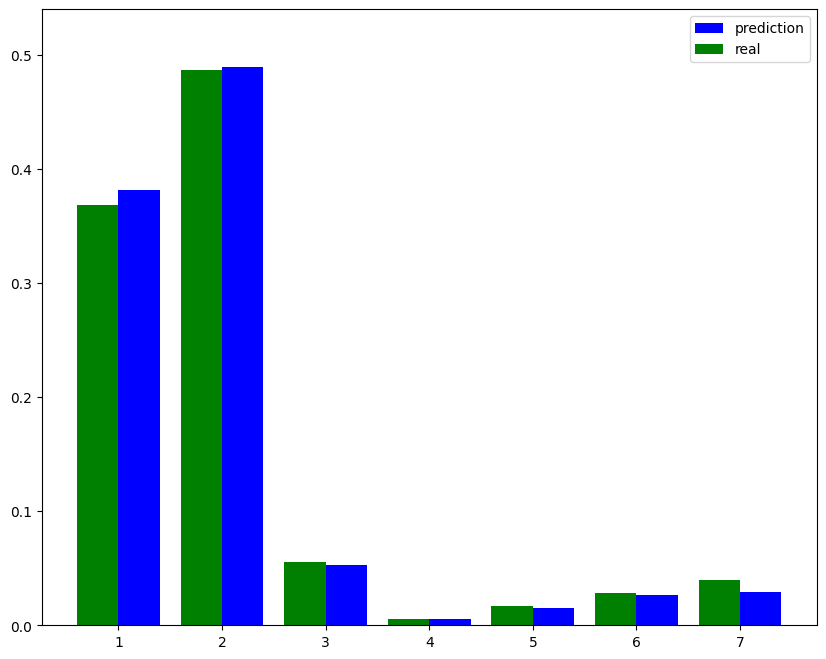

In [ ]:
# Визуализация предсказаний модели K-ближайших соседей в сравнении с реальными метками классов на тестовом наборе данных
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label="prediction", color="blue")
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label="real", color="green")
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

-Каково качество модели на тестовой выборке?

-Сравните ее с качеством логистической регрессии. Какая модель лучше? Почему?

-Каковы плюсы и минусы метода k ближайших соседей?

-Постройте ROC-кривую для метода k ближайших соседей.

-Рассчитайте площадь под ROC-кривой (AUC-ROC).

In [ ]:
# Точность KNN
pred_labels = optimal_clf.predict(test_feature_matrix)
knn_accuracy = accuracy_score(test_labels, pred_labels)
print("Accuracy:", knn_accuracy)

Accuracy: 0.7845


In [ ]:
# Точность логистической регрессии (пришлось поменять solver, так как солвер по умолчанию не справился с задачей)
clf = LogisticRegression(C=1, solver="newton-cholesky")
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

log_reg_accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", log_reg_accuracy)

Accuracy: 0.7215


In [ ]:
# Разность
print("Разность:", knn_accuracy - log_reg_accuracy)

Разность: 0.06299999999999994


Точность KNN: 0.7845

Точность логистической регрессии: 0.7215

**Сравнение качества моделей**:
Модель KNN показала более высокую точность по сравнению с логистической регрессией. Это означает, что KNN классифицирует больше экземпляров правильно на тестовой выборке, чем логистическая регрессия.



**Какая модель лучше и почему?**

Выбор модели зависит от различных факторов, включая:

- Обучение:

  - Процесс обучения в KNN минимален, поскольку алгоритм по сути запоминает обучающие данные. Время обучения ничтожно мало, поскольку оно проводится в соответствии с ленивым подходом к обучению.

  - Метод логист. регр. предполагает оценку параметров путём минимизации
   функции логистической потери с помощью таких методов, как градиентный спуск. Более быстрое обучение, особенно для больших наборов данных.

- Предположения:

  - KNN не делает предположений о распределении исходных данных и является нелинейным методом.

  -	Предполагается линейная зависимость между признаками и логарифмом вероятностей переменных.

- Многомерные данные:
  
  -  KNN страдает от «проклятия размерности». Используются методы сокращения количества признаков.

  - Может хорошо работать в многомерных пространствах, но для предотвращения переобучения может потребоваться регуляризация.
















**Плюсы и минусы метода K ближайших соседей**

Плюсы KNN:
- Простота и интуитивность: Легко понять и реализовать.
- Гибкость: Метод не требует предположений о распределении данных и может моделировать сложные зависимости, что делает его применимым к широкому кругу задач.
- Точность: Высокая точность прогнозов при правильном подборе k и метрики расстояния.

Минусы KNN:
- Вычислительная сложность: Большое потребление памяти и низкая скорость работы из-за хранения и вычисления расстояний между всеми обучающими и тестовыми образцами.
- Проблема с размерностью: В высокоразмерных пространствах расстояния между точками становятся менее информативными.
- Необходимость в нормализации данных: Поскольку KNN полагается на расстояния, данные необходимо нормально подвергать стандартизации или нормализации.

Таким образом, учитывая высокую точность, гибкость и простоту применения, метод K ближайших соседей оказывается более эффективным выбором в данной ситуации, чем логистическая регрессия.

 **Построим ROC-кривую для метода k ближайших соседей и посчитаем площадь под ней**

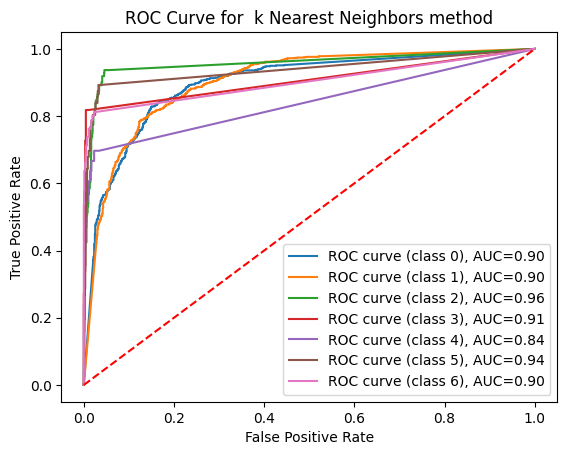

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

test_labels_bin = label_binarize(test_labels, classes=np.arange(1,8))
false_prate = dict()
true_prate = dict()
roc_auc = dict()
for i in range(7):
    false_prate[i], true_prate[i], _ = roc_curve(test_labels_bin[:, i], pred_prob[:, i])
    roc_auc[i] = auc(false_prate[i], true_prate[i])

plt.figure()
for i in range(7):
    plt.plot(false_prate[i], true_prate[i], label=f"ROC curve (class {i}), AUC={roc_auc[i]:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for  k Nearest Neighbors method')
plt.legend()
plt.show()